# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 1

## Student 1 
### Name : Marios Marinos  
### ID : 5353106

## Student 2
### Name : Ynze Ter Host
### ID : 4701682   

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [7]:
# general ml libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import (
    confusion_matrix
) 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
# general libraries
from itertools import product
import random
import os
import warnings
warnings.filterwarnings('ignore')
# libraries to create the n-grams 
import nltk
from nltk.util import ngrams

## 1. Familiarization and discretization task – 1 A4

In [8]:
# creating the elbow curve
def createElbow(df):
    distortions = []
    K = range(1, 10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)
    
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')

    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [9]:
# Load the data and remove background flows.
df_10 = pd.read_csv("dataset_lab3/dataset_10/capture20110818.binetflow")
# drop the background flows so as to have only infected flows.
df_10.drop(df_10.loc[df_10.Label.str.contains("Background")].index.values, inplace=True)
df_10.reset_index(inplace=True)

In [10]:
df_10.head()

,index,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,532,2011/08/18 10:19:15.693956,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,0.0,0.0,3049,978731,245317,flow=From-Normal-V51-Grill
1,822,2011/08/18 10:19:18.143576,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,0.0,0.0,14,924,462,flow=From-Normal-V51-Grill
2,842,2011/08/18 10:19:18.303590,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,0.0,0.0,14,924,462,flow=From-Normal-V51-Grill
3,1021,2011/08/18 10:19:19.838272,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,0.0,0.0,2,400,74,flow=From-Normal-V51-Stribrek
4,1022,2011/08/18 10:19:19.839123,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,0.0,0.0,2,400,74,flow=From-Normal-V51-Stribrek


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [11]:
# find the Infected hosts.
Infected_hosts = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))]
# find the un-infected hosts.
Normal_hosts = df_10.loc[np.where(~df_10.Label.str.contains('Botnet'))]

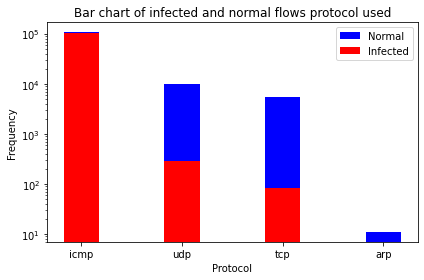

In [12]:
plt.bar(df_10['Proto'].value_counts().index, df_10['Proto'].value_counts(), color = 'blue', label='Normal', width=0.35)
plt.bar(Infected_hosts['Proto'].value_counts().index, Infected_hosts['Proto'].value_counts(), color = 'red', label='Infected', width=0.35)
plt.yscale('log')
plt.title("Bar chart of infected and normal flows protocol used")
plt.xlabel('Protocol')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


The first feature we think is important is the Protocol that Normal flows vs botnet flows used. We decided to plot in a log scale, since most flows had been using icmp and it was dominating the rest. By the bar chart, we observe that icmp dominates in the infected hosts, whereas the rest of the protocols make up half of both infected and uninfected traffic. This makes the feature relevant to model the behavior of the infected hosts.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f969b624310>,
 'caps': [<matplotlib.lines.Line2D at 0x7f969b6249d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f969b635f70>,
 'medians': [<matplotlib.lines.Line2D at 0x7f969eb360d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f969eb36430>,
 'means': []}

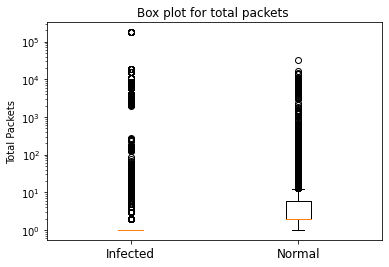

In [13]:
# plt.boxplot(df_10['TotBytes'])
# plt.show()
# plt.boxplot(Infected_hosts['TotBytes'])
# plt.yscale('log')
# Multiple box plots on one Axes
fig, ax = plt.subplots()

data = [Infected_hosts['TotPkts'], Normal_hosts['TotPkts']]
plt.yscale('log')
plt.ylabel('Total Packets')
plt.title("Box plot for total packets ")
ax.set_xticklabels(['Infected', 'Normal'], fontsize=12)

ax.boxplot(data)

In this boxplot the total packets in a flow are plotted for the infected and normal categories. For the normal flows a larger distribution can be observed (higher variance) and a higher mean in general. Both the variance and mean are practically zero for the infected cases, but when it comes to outliers these infected flows actually have larger ones.

### 1b. Discretize selected features

# Selected features : packet type + packet size

For packet type (TCP/UDP, etc.) it is evident that we have 4 different categories (icmp, udp, tcp, arp) so discretize using 4 bins.

In [14]:
df_10['Proto'].value_counts()

icmp    106690
udp      10073
tcp       5425
arp         11
Name: Proto, dtype: int64

To discretize the Total packet size we need somehow to determine how many clusters we we have (e.g. small/med/large). For this, I'll use an elbow curve. 

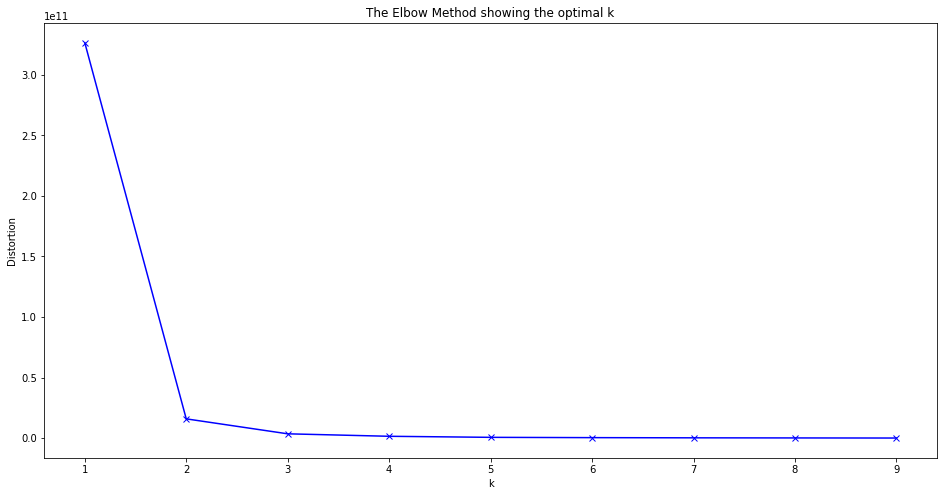

In [15]:
# use Elbow method to determine the bins of Total Packets size.
createElbow(df_10['TotPkts'].to_numpy().reshape(-1, 1))

Combining the two features of Protocols and the Total packets sent by the host. 

In [16]:
def discetize_feature(df):
    # encode the 4 different values in 0,1,2,3
    le = LabelEncoder()
    Protocols = le.fit_transform(df['Proto']).reshape(-1, 1)
    # discretise based on the elbow method using 3 bins.
    est = KBinsDiscretizer(n_bins= 3, encode='ordinal', strategy='quantile')
    TotBytes = est.fit_transform(df['TotPkts'].to_numpy().reshape(-1, 1))
    # get the unique values so as to create the pairs that might be in the two features.
    values_prot = np.unique(Protocols)
    values_bytes = np.unique(TotBytes)
    # create all possible pairs of [0-3] with [0-2] to map them.
    c = list(product(values_prot, values_bytes))
    Labels = {x : index for index, x in enumerate(c)}
    # insert the two columns in a np array so we have a 122199, 2 shape numpy array.
    Combined_features = np.concatenate((Protocols, TotBytes), axis = 1)
    # initialize an empty array to fill it with the new discrete values.
    Discretized_feature = np.zeros((Combined_features.shape[0], 1))
    for index, row in enumerate(Combined_features):
        Discretized_feature[index] = Labels.get(tuple(row))

    final_feature = pd.Series(Discretized_feature.reshape(-1,))

    return final_feature


In [34]:
"""
Function to plot histogram for 3-grams.
input : series is the density distribution, threshold is which bins to plot based on the density they have. If the element in series has > threshold is plotted, otherwise is added to other.
return : plots the histogram.
"""
def plot_histogram(series, title, threshold = 0.02):
    mask = series > threshold
    # for 3-grams that doesn't have a density of 1.5% we sum them and 
    # plot them as 'other' since it will be the tails.
    tail_prob = series.loc[~mask].sum()
    series = series.loc[mask]
    series['other'] = tail_prob
    series = series.round(4)
    ax = series.plot(kind='bar')
    plt.xticks(rotation=30)
    plt.xlabel('3-gram')
    plt.ylabel('Density')
    plt.title(title)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()

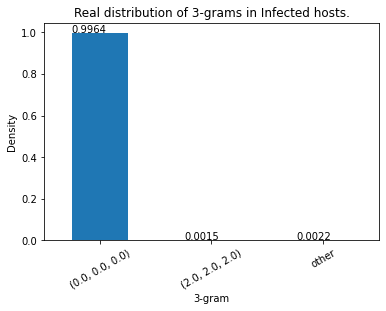

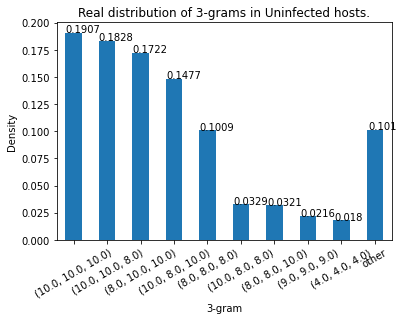

In [37]:
def plot_hist(df, threshold, which):
    which_host = 'Infected' if which else 'Uninfected'
    features = discetize_feature(df)
    # create the 3-grams of discretised symbol.
    n = 3
    trigrams = list(ngrams(features, n))
    # also create a Series with the trigrams.
    trigrams_Series = pd.Series(trigrams)
    # plot the ground truth distribution
    plot_histogram(trigrams_Series.value_counts(normalize=True), f"Real distribution of 3-grams in {which_host} hosts.", threshold = threshold)
    # 0 as discretized feature is small packet size and using icmp protocol

plot_hist(Infected_hosts, 0.001, True)
plot_hist(Normal_hosts, 0.01, False)

In [22]:
# applying discretazion in all data from scenario 10.
all_data = discetize_feature(df_10)
all_data

0         2.0
1         2.0
2         2.0
3         3.0
4         3.0
         ... 
122194    1.0
122195    1.0
122196    3.0
122197    3.0
122198    2.0
Length: 122199, dtype: float64

### 1b. Answers and explanation

In [122]:
# TODO : Do you observe any behavior in the two features that could be useful for detecting the infection? Explainand visualize.

## 6.Botnet profiling task – 1/2 A4

### 6a. Learn a sequential model

Create a binary vector for each unique n-gram for the picked malicious host, assign 1 if the trigram occurs in the malicious host, otherwise assign 0. Do the same for all the hosts (malicious and not) and then compare it to the malicious one. If the cosine is above a threshold, classify it as malicious otherwise is normal. Do that for all the scenarios and return the 4 confusion matrices for each scenario.

In [146]:
def createN_grams(host, n):
    # create the 3-grams of discretised symbol.
    trigrams = list(ngrams(host, n))
    # also create a Series with the trigrams.
    trigrams_Series = pd.Series(trigrams)
    return trigrams_Series
"""
Pass the discretised feature as series and the number for n-grams that you want to split this feature.
return : returns the binary vector that corresponds on whether the n-gram exists or not.
"""
def createBinaryVector(host, n=3):
    host = createN_grams(host, n)
    # repeats is the number of the n-grams
    trigrams_all = [trigram for trigram in product([float(x) for x in range(0,12)], repeat=n)]
    # unique trigrams that can exist in a host are trigrams_Series.value_counts().index.
    binary_vector = {trigram : 0 for trigram in trigrams_all}
    # if the trigram exists in the profile, assign 1 to the binary vector.
    for trigram in host.unique():
        binary_vector[trigram] = 1
    return binary_vector

In [147]:
"""
This function does the profiling task in a specific dataset, calculates the cosine and decide whether that's a true positive or not.
Input : profile : is the profile that we will compare everything to, data : is the data that we will pass to do the profiling task. (e.g. we do that for the 2 subsets of our original data set : the one that have only the botnet hosts and the one that have only the normal hosts.)
Return : returns the predictions according to a threshold given.
"""
def profilingTask(profile, data, threshold = 0.6):
    predicts = []
    #these are the unique hosts that have botnet flows.
    unique_adresses = data.groupby(by=['SrcAddr']).size().index
    for unique_host in unique_adresses:
        host = data[data['SrcAddr'] == unique_host].reset_index()
        # discretize the host.createProfile
        host = discetize_feature(host)
        # create the 3grams and create the binary vector.
        host = createBinaryVector(host)
        # do the comparison of the profile and one of the hosts.
        profile_vector = np.fromiter(profile.values(), dtype=float).reshape(-1, 1)
        host_vector = np.fromiter(host.values(), dtype=float).reshape(-1, 1)
        cosine = 1 - distance.cosine(profile_vector, host_vector)
        # print(f"cosine sim is : {cosine}")
        # put prediction 1 if they are very similar according to threshold otherwise 0.
        predicts.append(1) if cosine > threshold else predicts.append(0)
    
    return predicts

def compareAll(malicious_profile, Infected, Normal, threshold):
    mal_hosts = len(Infected.groupby(by=['SrcAddr']).size().index)
    norm_hosts = len(Normal.groupby(by=['SrcAddr']).size().index)
    # if it's normal host ground truth -> 0, if its botnet host ground truth -> 1
    ground_truth = [1 for _ in range(mal_hosts)]
    ground_truth.extend([0 for _ in range(norm_hosts)])
    # initialize a predictions array.
    predictions = []
    # Do the predictions based on profiling.
    predicts_malicious = profilingTask(malicious_profile, Infected, threshold)
    # append the malicious predictions.
    predictions.extend(predicts_malicious)
    predicts_normal = profilingTask(malicious_profile, Normal, threshold)
    # append the normal predictions.
    predictions.extend(predicts_normal)
    cm = confusion_matrix(ground_truth, predictions)
    return cm

In [148]:
"""
this functions prints the confusion matrix.
"""
def evaluation(results, which):
    which_method = {0 : 'Profiling', 1 : 'Fingerprinting', 2 : 'Packet level', 3 : 'Host Level'}
    fig, axs = plt.subplots(2, 2)
    # flatten so we can iterate over
    axs = axs.flatten()
    fig.set_size_inches(14, 7)
    classes = ['Normal', 'BotNet']
    # set the title accordingly.
    fig.suptitle('Confusion matrices for all data sets using the method ' + which_method[which], fontsize=16)
    data_sets = [x for x in range(9,13)]
    for key, ax in zip(data_sets, axs):
        result = results[key]
        ax.set_title(f"Scenario {key}", fontsize=12)
        sns.heatmap(result, ax=ax, square=True, fmt='g', annot=True,cmap='YlGnBu', xticklabels=classes, yticklabels=classes)

    fig.tight_layout()
    plt.show()



In [149]:
"""
This function does the whole procedure of doing the profiling task in a specific scenario end-to-end. It returns the respective confusion matrix accordingly.
"""
def run_single_dataset(df, threshold):
    # set a seed to always pick the same random host.
    random.seed(42)
    n = 3
    # find the Infected hosts.
    Infected_hosts = df.loc[np.where(df.Label.str.contains('Botnet'))]
    # find the un-infected hosts.
    Normal_hosts = df.loc[np.where(~df.Label.str.contains('Botnet'))]
    # pick a random malicious ip (same all the time since seed=42)
    foo = list(Infected_hosts.groupby(by=['SrcAddr']).size().index)
    malicious_ip = random.choice(foo)
    # 2nd step create the profile.
    # pick one of the malicious hosts.
    malicious_host = Infected_hosts[Infected_hosts['SrcAddr'] == malicious_ip].reset_index()
    malicious_host_discretised = discetize_feature(malicious_host)
    malicious_profile = createBinaryVector(malicious_host_discretised, n)
    # 3rd step. Do the comparison and return the confusion matrix
    cm = compareAll(malicious_profile, Infected_hosts, Normal_hosts, threshold)
    return cm

### 6b. Analysis and answers to the questions.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


For Fingerprinting task what we need to do first is to split the data in train/test. Then, we use the train malicious host and the normal to figure out which trigrams are the fingerprints. A fingerprint is when a trigram occurs in ALL of the train malicious host and in NONE of the train normal hosts. Finally, we search for these fingerprints in the test data set hosts and if any of these fingerprints occur in the test hosts we classify that as malicious.

In [127]:
"""
This function uses a train data set to learn which trigrams will be the fingerprints so as to determine the malicious host.

Input : ratio : is the ratio that we want to do our split train/test data.

Return : it returns a set that containts the trigrams fingerprints.
"""
def trainFingerPrints(df, ratio=0.5, n = 3):
    # find the Infected hosts.
    Infected_hosts = df.loc[np.where(df.Label.str.contains('Botnet'))]
    # find all the infected ips.
    infected_ips = list(Infected_hosts.groupby(by=['SrcAddr']).size().index)
    random.seed(42)
    train_mal_ips = random.sample(infected_ips, int(ratio * len(infected_ips)))
    # find the hosts for testing malicious and return it.
    test_malicious = [str(x) for x in infected_ips if x not in train_mal_ips]
    # initialize a set for fingerprints.
    fingerprints = set()
    # for each malicious check whether the trigram is there or not.
    for i, malicious_ip in enumerate(train_mal_ips):
        df_malicious = Infected_hosts[Infected_hosts['SrcAddr'] == malicious_ip].reset_index()
        # discretize the host.createProfile
        mal_host = discetize_feature(df_malicious)
        # create the n-grams (n = 3 here)
        mal_host = createN_grams(mal_host, n)
        # insert the unique n-grams in the fingerprints. 
        unique_ngrams = set(mal_host.unique())
        # put all the trigrams from the first malicious in the fingerprints and then start removing the ones that do
        # not exist in the other malicious.
        fingerprints = fingerprints | unique_ngrams if i == 0 else fingerprints & unique_ngrams 
    
    # find the bening hosts and pick random len(hosts) * train ratio of bening hosts.
    Normal_hosts = df.loc[np.where(~df.Label.str.contains('Botnet'))]
    normal_ips = list(Normal_hosts.groupby(by=['SrcAddr']).size().index)
    random.seed(42)
    train_norm_ips = random.sample(normal_ips, int(ratio * len(normal_ips)))
    # find the hosts for testing and return it.
    test_normal = [str(x) for x in normal_ips if x not in train_norm_ips]

    for bening_ip in train_norm_ips:
        df_bening = Normal_hosts[Normal_hosts['SrcAddr'] == bening_ip].reset_index()
        # discretize the host.createProfile
        ben_host = discetize_feature(df_bening)
        # create the n-grams (n = 3 here)
        ben_host = createN_grams(ben_host, n)
        # insert the unique n-grams in the fingerprints. 
        unique_ngrams = set(ben_host.unique())
        # take the difference between the 2 sets of fingerprints and bening ngrams.
        fingerprints = fingerprints - unique_ngrams

    return fingerprints, test_malicious, test_normal

In [135]:
def calculateConfusion(df, fingerprints, test_malicious, test_bening):
    # if it's normal host ground truth -> 0, if its botnet host ground truth -> 1
    ground_truth = [1 for _ in range(len(test_malicious))]
    ground_truth.extend([0 for _ in range(len(test_bening))])
    # initialize a predictions array.
    predictions = []
    # Do the predictions based on profiling.
    predicts_malicious = fingerprinting_prediction(df, fingerprints, test_malicious)
    # append the malicious predictions.
    predictions.extend(predicts_malicious)
    predicts_normal = fingerprinting_prediction(df, fingerprints, test_bening)
    # append the normal predictions.
    predictions.extend(predicts_normal)
    cm = confusion_matrix(ground_truth, predictions)
    return cm

def fingerprinting_prediction(df, fingerprints, hosts):
    predicts = []
    n = 3
    for host in hosts:
        df_host = df[df['SrcAddr'] == host].reset_index()
        # discretize the host.createProfile
        host = discetize_feature(df_host)
        # create the n-grams (n = 3 here)
        host = createN_grams(host, n)
        # insert the unique n-grams in the fingerprints. 
        unique_ngrams = set(host.unique())
        # if any of the unique_ngrams is in fingerprints then predict it's malicious (1) otherwise put 0.
        # print("hi", fingerprints & unique_ngrams)
        predicts.append(1) if bool(fingerprints & unique_ngrams) else predicts.append(0)
    
    return predicts


In [150]:
def runAllDatasets(which_technique, cosine_threshold = 0.5, train_ratio=0.5):
    # load the 4 different scenarios.
    # for each data set save the result confusion matrix to a dictionary to plot them all together.
    results = {}
    for x in range(9,13):
        path = f'/home/marios/Documents/GitHub/CDA_CS4035/Lab3/dataset_lab3/dataset_{x}/'
        for file in os.listdir(path):
            if file.endswith(".binetflow"):
                data = os.path.join(path, file)
        
        # Load the data and remove background flows.
        df = pd.read_csv(data)
        # drop the background flows so as to have only infected flows.
        df.drop(df.loc[df.Label.str.contains("Background")].index.values, inplace=True)
        df.reset_index(inplace=True)
        # if true, run the profiling task, otherwise run the fingerprinting task.
        if which_technique == 0:
            cm = run_single_dataset(df, cosine_threshold)
        else:
    # calculate the finger prints from the data set, and then do the calculation of confusion matrix and the predictions.
            fingerprints, test_malicious, test_bening = trainFingerPrints(df, train_ratio)
            cm = calculateConfusion(df, fingerprints, test_malicious, test_bening)
    
        results[x] = cm

    evaluation(results, which_technique)

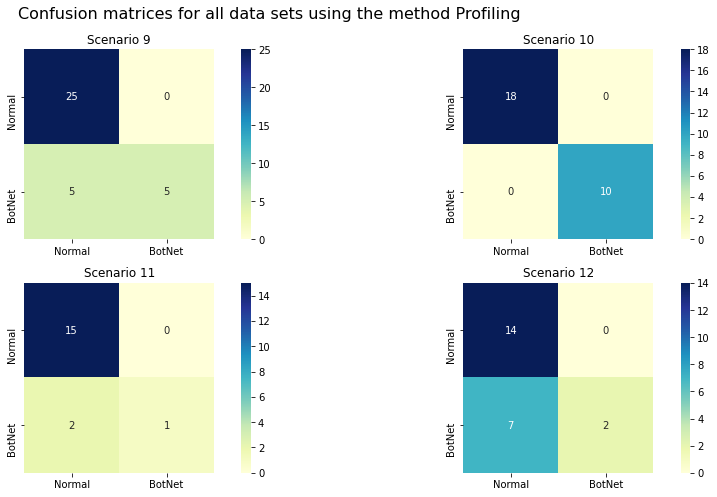

----------------------------------------------------------------------------------------------------


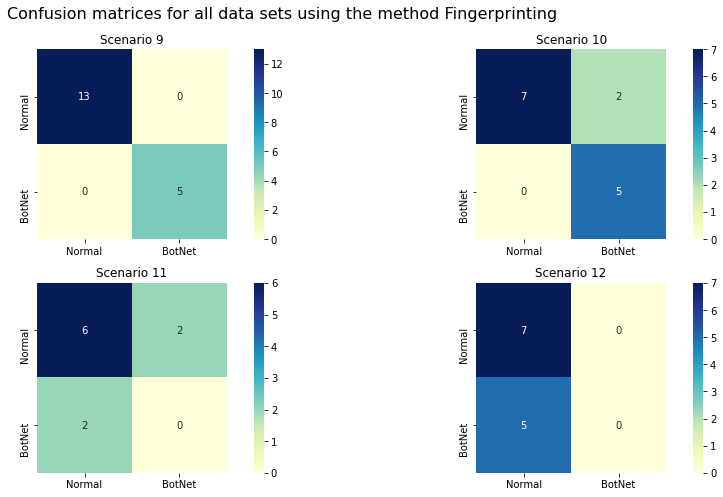

In [151]:
# run profiling
runAllDatasets(0, cosine_threshold=0.6)
print(100*"-")
# run fingerprinting
runAllDatasets(1, train_ratio=0.5)

### 7b. Analysis and answers to the questions.

## 8. Bonus Task 1/2 A4

### 8a. Provide implementation and analysis.

In [142]:
def preProcess(data):
    # Preprocessing
    normal = data[data.Label.str.contains("Normal")].copy()
    normal['Label'] = 0
    malicious = data[data.Label.str.contains("Botnet")].copy()
    malicious['Label'] = 1

    df = pd.concat([normal, malicious])
    df = df.drop(columns=['StartTime', 'Dur', 'Sport', 'DstAddr', 'Dport', 'sTos', 'dTos'])
    return df

# host is a boolean of whether we use host level so as to aggregate the data or in packet level.
def featureEngineering(df, host):
    ### Feature Engineering
    # One-Hot encoding
    oneHotFeatures = ['SrcAddr', 'Proto', 'Dir']
    hotEncoder = OneHotEncoder()
    hotEncoding = pd.DataFrame(hotEncoder.fit_transform(df[oneHotFeatures]).toarray())
    encoded = df.join(hotEncoding)
    encoded = encoded.drop(columns=oneHotFeatures)

    # Label encoding
    labelFeatures = ['State']
    labelEncoder = LabelEncoder()
    labelEncoding = pd.DataFrame(labelEncoder.fit_transform(encoded[labelFeatures]))
    labelEncoding.columns = ['State']
    encoded = encoded.drop(columns=labelFeatures)
    encoded = encoded.join(labelEncoding)

    # Scaling
    numericalFeatures = ['TotPkts', 'TotBytes', 'SrcBytes']
    scaler = StandardScaler()
    scaling = pd.DataFrame(scaler.fit_transform(encoded[numericalFeatures]),columns = numericalFeatures)
    encoded[numericalFeatures] = scaling[numericalFeatures]
    
    if host:
        # group per host and aggregate to the mean.
        encoded['SrcAddr'] = df['SrcAddr']
        encoded = encoded.groupby(by=['SrcAddr']).mean()

    return encoded



In [143]:
def trainclassifier(encoded, host, test_ratio = 0.2):
    ### Create Training and Test data

    # Get labels
    labels = encoded['Label']
    features = encoded.drop(columns=['Label'])

    # Split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = test_ratio, random_state = 42)
    
    if not host:
        # SMOTE to counter class imbalance
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    # Train random forest classifier
    clf = RandomForestClassifier(n_estimators = 100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    return y_pred, y_test

In [144]:
# if which level True we run on host level else we run on packet level.
def run_classifier(which_level):
    # load the 4 different scenarios.
    # for each data set save the result confusion matrix to a dictionary to plot them all together.
    results = {}
    for x in range(9,13):
        path = f'/home/marios/Documents/GitHub/CDA_CS4035/Lab3/dataset_lab3/dataset_{x}/'
        for file in os.listdir(path):
            if file.endswith(".binetflow"):
                data = os.path.join(path, file)
        
        # Load the data and remove background flows.
        data = pd.read_csv(data)
        # Remove background flows
        data = data[~data.Label.str.contains("Background")].reset_index()
        data = data.drop(columns='index')
        df = preProcess(data)
        # if which level is 3 (means host level) else w do packet level
        if which_level==3:
            encoded = featureEngineering(df, True)
            # get the predictions
            predictions, ground_truth = trainclassifier(encoded, True, 0.4)
        else :
            encoded = featureEngineering(df, False)
            predictions, ground_truth = trainclassifier(encoded, False, 0.2)
        # calculate the confusion matrix and save it.
        cm = confusion_matrix(ground_truth, predictions)

        results[x] = cm
    
    evaluation(results, which_level)

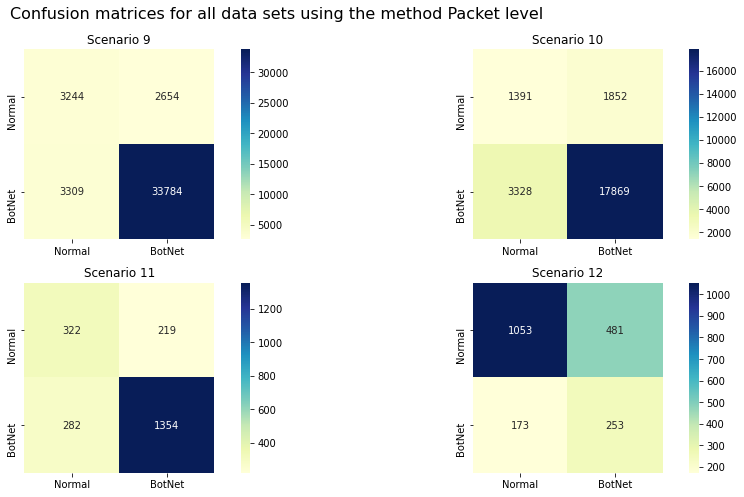

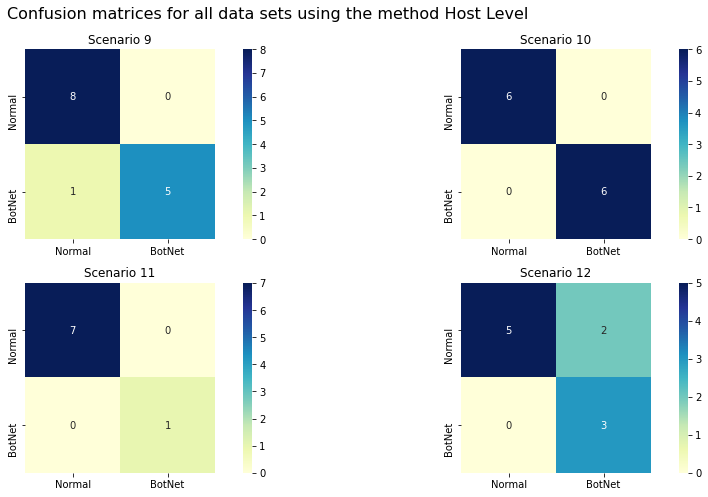

In [145]:
# run on packet level
run_classifier(2)
# run on host level
run_classifier(3)